University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi  

# Week 5 exercises

For this week exercises, you can implement your code using either Autograd or PyTorch as you prefer.

Autograd provides a simpler, more NumPy-like interface, while PyTorch provides a more powerful framework for advanced users. If in doubt, it is probably better to try Autograd. You can port your code to PyTorch later if you wish to experiment with that.

Please see Chapter 10 of the course notes and this week's computer tasks for more details and examples of use of both frameworks.

-----------------------------------

*Hints*:

- If you are using Autograd, make sure you always import `autograd.numpy` instead of regular `numpy` and `autograd.scipy` instead of regular `scipy` to allow Autograd to differentiate any functions you use. This can usually be achieved easily using
  ```
  import autograd.numpy as np
  import autograd.scipy.special as scs
  ```
  and using the packages via `np` and `scs` aliases as usual.
- The import trick above is not needed for PyTorch, which does not support differentiation of NumPy and SciPy functions, only its own functions.
- If you are having problems with Autograd, please note the following:
  * Autograd does not support subscripted assignment (e.g. `a[1] = 2`) and will give a mysterious error if you try.
  * Autograd does not support named function arguments (e.g. `f(foo=1, bar=2)`) and will give a mysterious error if you try.
  * Autograd can only differentiate functions in `autograd.numpy` and `autograd.scipy`. Check your imports if you get mysterious errors.
- If you use PyTorch, please make sure to use the `double` data type. The accuracy of the default data type `float` may not be sufficient.

## 1. Gradients of a multivariate normal likelihood (4 points)

We will test the evaluation and gradient of the multivariate normal likelihood using a covariance matrix specified by a Gaussian process. A 1D Gaussian process is a distribution over continuous functions such that the joint distribution over any finite set of points is multivariate normal (Gaussian). We will use the so-called *squared exponential* covariance function over input points $t_1, \dots, t_n$ defined by  
$$ k(t_i, t_j; \ell) = \exp\left( -\frac{(t_i-t_j)^2}{2 \ell^2} \right), $$
where the parameter $\ell$ is called the *length scale* of the process.

1. Write a function to generate a $3 \times 3$ covariance matrix $K$ such that $K_{i,j} = k(t_i, t_j; \ell)$ where $t_1 = 1, t_2 = 2, t_3 = 3$ as a function of $\ell$.
2. Evaluate the log-pdf of the vector $x = (1, 0, 1)$ under a multivariate normal with $\textbf{0}$ mean and the above covariance matrix $K$ with $\ell = 2$. Report the value of the log-pdf to Moodle.
3. Evaluate the finite difference approximation to the gradient of the log-pdf with respect to $\ell$ at the point $\ell=2, x=(1, 0, 1)$ with $h = 10^{-3}$ (`1e-3`) and report it to Moodle. *Note*: Use the first-order finite difference formula presented in Section 10.2 of the lecture notes
4. Evaluate the exact gradient of the log-pdf with respect to $\ell$ at the point $\ell = 2, x = (1, 0, 1)$ using automatic differentiation and report it to Moodle.

*Hint*: you can generate a matrix of differences of $t$ values in NumPy using the `None` index to create a new dimension:
```
t = np.array([1.0, 2.0, 3.0])
dt = t[:,None] - t[None,:]
```

In PyTorch, the corresponding trick works but the input needs to be a `tensor`:
```
torch.set_default_dtype(torch.double)
# Uncomment this to run on GPU:
# torch.set_default_tensor_type(torch.cuda.DoubleTensor)

t = torch.tensor([1.0, 2.0, 3.0])
dt = t[:,None] - t[None,:]
```

Useful PyTorch functions for evaluating the multivariate normal density that differ from NumPy: `torch.linalg.solve()`, `torch.dot()`

In [110]:
import autograd.numpy as np
import autograd.scipy.stats as stats
from autograd import grad 
from autograd.scipy.linalg import det, solve

t = [1, 2, 3]
n = 3

def k(t_i, t_j, l):
    return np.exp(-((t_i-t_j)**2)/(2*l**2))

def K(l):
    t = np.array([1, 2, 3])
    dt = t[:, None] - t[None, :]
    K = np.exp(- dt**2 / (2 * l**2))
    return K

def g(l):
    gen_K = K(l)
    x = np.array([1, 0, 1])
    mean = np.zeros(3)
    
    n = x.shape[0]
    diff = x - mean
    sol = np.dot(diff, solve(gen_K, diff))
    
    return -0.5 * n * np.log(2 * np.pi) - 0.5 * np.log(det(gen_K)) - 0.5 * sol

logpdf_res = g(2.0)

print(f'(2) {logpdf_res}')

h=1e-3
fin_diff = (g(2+h) - g(2)) / h
print(f'(3) g\'(x)={fin_diff} ')

# Unfortunatly, wasn't able to make it run. at the line solve(gen_K, diff), solve doesn't handle well the ArrayBox
print(grad(g)(2.0))
# print(f'(4) grad g\'(x)={}')


(2) -21.219486088440927
(3) g'(x)=-34.738367964504135 


NotImplementedError: VJP of solve wrt argnums (0,) not defined

## 2. Maximum likelihood estimation of the gamma distribution (4 points)

In this exercise we test maximum likelihood estimation of the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) to a given data set.

Note that the parameters $\alpha$ and $\beta$ of the Gamma distribution need to be positive. This can be accomplised by using $a$ and $b$ satisfying $\alpha = \exp(a)$ and $\beta = \exp(b)$ as variables in the optimization.

1. Load the data set $\mathcal{D} = \{ x_i | i = 1, \dots, n \}$ using the function below.
2. Find the maximum likelihood fit for the parameters $\alpha$ and $\beta$ of the Gamma distribution $\Gamma(\alpha, \beta)$ when $x_i \sim \Gamma(\alpha, \beta)$.
3. Plot the maximum likelihood distribution together with a normed histogram of the data to check your estimates.
4. Report your estimates $\alpha$ and $\beta$ in Moodle. (*Note*: please remember to report $\alpha$ and $\beta$, not $a$ and $b$.)

*Hints*: 
- Feel free to use the implementation of the Gamma distribution pdf provided below. Note that here we are using the shape-rate parametrization of the Gamma pdf.
- Note that we are performing maximum-likelihood estimation, not Bayesian inference. There is no prior here. So, there is no prior density that needs to be corrected when you transform from $\alpha \rightarrow a$ and $\beta \rightarrow b$.

(2) alpha=6.495219998215713 beta=1.6332623908343311


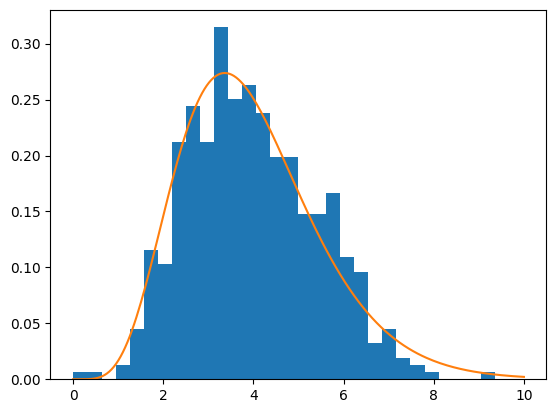

In [100]:
# Autograd code
import autograd.scipy.special as scs
from autograd.scipy import stats
import autograd.numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import autograd

data = pd.read_csv('https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/toydata.txt', sep='\t', header=None).values

def gamma_logpdf_autograd(x, alpha, beta):
    """Log pdf of the Gamma distribution."""
    return (alpha*np.log(beta) - scs.gammaln(alpha) + (alpha-1) * np.log(x) - beta * x)

def target(params):
    a, b = params
    alpha, beta = np.exp(a), np.exp(b)
    return -np.sum(gamma_logpdf_autograd(data, alpha, beta))

# print(f'(1) {autograd.grad(lambda x: gamma_logpdf_autograd(x, 5, 5))(5.0)}')
plt.hist(data, bins=30, density=True)

a, b = minimize(target, [0, 0]).x
alpha, beta = np.exp(a), np.exp(b)
x = np.linspace(0, 10, 200)
plt.plot(x, stats.gamma.pdf(x, a=alpha, scale=1/beta))
print(f'(2) alpha={alpha} beta={beta}')


## 3. Student-$t$ regression (6 points)

In this task we will apply linear regression to data from the Framingham Heart Study that studies the association between heart disease and its causes.

A description of the data and its fields can be found at http://www.maths.utas.edu.au/DHStat/Data/Flow.html (see also problem 10.4 in the computer tasks done in class).

In this exercise, we will use the [Student-$t$ distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) for the noise. This provides a form of robust regression due to the heavy tails of the Student-$t$ distribution, which makes it less affected by outliers.

Linear regression fit to scalar $x_i, y_i$ involves fitting the model
$$ y_i = \alpha + \beta x_i + \epsilon_i, $$
where $\beta$ is the regression coefficient and $\alpha$ is the intercept. Assuming $\epsilon_i \sim p(\epsilon_i | \sigma)$, the log-likelihood of the model is
$$ \log p(Y | X, \alpha, \beta, \sigma) = \sum_{i=1}^n \log p(y_i | x_i, \alpha, \beta, \sigma)
  = \sum_{i=1}^n \log p_{\epsilon_i}(y_i - \alpha - \beta x_i;\; \sigma), $$
where $p_{\epsilon_i}(y_i - \alpha - \beta x_i;\; \sigma)$ is the probability density of
the noise $\epsilon_i$, evaluated at $y_i - \alpha - \beta x_i$. 
In Problem 3 from Week 2, and in the computer task 10.3 and 10.4, we used a normal distribution for $p_{\epsilon_i}$ whereas here we will use the Student-$t$ distribution with $\nu = 5$ degrees of freedom and scale parameter $\sigma = 1$.

1. Load the data using the below code and plot the data.
2. Fit the data using standard linear regression with normally distributed errors ($p_{\epsilon_i} = \mathcal{N}(\epsilon_i;\; 0, \sigma^2)$ with $\sigma^2 = 1$). Report the $\alpha$ and $\beta$ you found in Moodle. (*Hint*: Problem 3 from Week 2 contains the formulas for $\alpha$ and $\beta$.)
3. Implement linear regression using the Student-$t$ log-likelihood function ($p_{\epsilon_i} = \text{Student-}t(\epsilon_i;\; 0, \sigma, \nu)$) with degrees of freedom (df) $\nu = 5$ and $\sigma = 1$, and maximise it (i.e. minimise the negative log-likelihood). Plot the fitted regression line in the same figure as the data.
4. Compare the coefficients $\alpha$ and $\beta$ you found for Student-$t$ regression with those from the standard linear regression. What can you observe? Report the coefficients you found in Moodle.

*Hint*: Feel free to use the Student-$t$ log-likelihood function implementations provided below.

(2) Estimate of alpha=131.73220676134514 beta=0.06969627715093442
(4) Linreg alpha=137.93151039484434 beta=0.008185544050881016


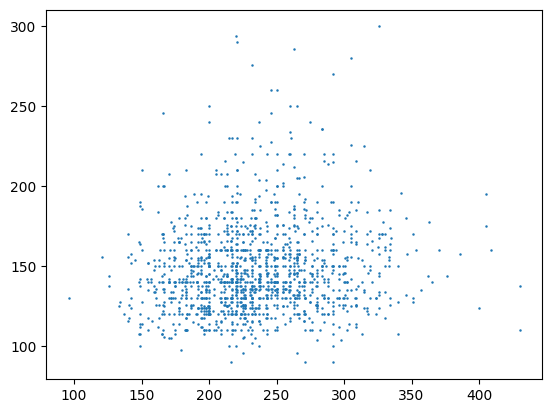

In [102]:
# Code for autograd
%matplotlib inline
import pandas as pd
import autograd.numpy as np
import autograd.scipy.special as scs
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# load the data from CSV file using pandas
fram = pd.read_csv('https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/fram.txt', sep='\t')
# convert the variables of interest to numpy arrays
# input: Blood cholesterol level
x = fram['CHOL'].values
# target: Systolic blood pressure, examination 1
y = fram['SBP'].values
plt.scatter(x, y, s=0.6)

beta_estimate = np.sum((y - np.mean(y)) * (x - np.mean(x))) / np.sum((x - np.mean(x)) ** 2)
alpha_estimate = np.mean(y) - beta_estimate*np.mean(x)

print(f'(2) Estimate of alpha={alpha_estimate} beta={beta_estimate}')

nu = 5

def student_logpdf_autograd(x, nu):
    """Log pdf of Student-t distribution with nu degrees of freedom."""
    return scs.gammaln(0.5*(nu+1)) - scs.gammaln(0.5*nu) - 0.5*np.log(nu*np.pi) - 0.5*(nu+1)*np.log(1 + x**2/nu)

def f(beta, alpha, x):
    return beta*x + alpha 

def ll(params, x, y_actual, nu):
    beta, alpha = params
    resi = y_actual - f(beta, alpha, x)

    return -np.sum(student_logpdf_autograd(resi, nu))

res = minimize(ll, [beta_estimate, alpha_estimate], args=(x, y, nu))
beta, alpha = res.x

print(f'(4) Linreg alpha={alpha} beta={beta}')

## 4. Variational inference for a mixture model (6 points)

In this problem, you are asked to estimate the posterior over the parameters of a mixture model using variational inference.

Find the posterior for the mixing weight $w$ and means $\mu_1, \mu_2$ in the normal mixture model
$$ p(x_i | \pi, \mu_1, \mu_2) = w \mathcal{N}(x_i;\; \mu_1, 1^2) + (1-w) \mathcal{N}(x_i;\; \mu_2, 1^2) $$
for the data set loaded below.

In order to ensure $0 \le w \le 1$, we will reparametrise it using the logistic transformation as $w = 1 / (1 + \exp(-\gamma))$. 

We will use normal priors for $\mu_1, \mu_2$ and a logistic-normal prior for $w$, which is equivalent to setting a normal prior for $\gamma$. The exact priors are
$$ p(\mu_1) = \mathcal{N}(\mu_1;\; 0, \sqrt{10}^2) \quad 
   p(\mu_2) = \mathcal{N}(\mu_2;\; 0, \sqrt{10}^2) \quad
   p(\gamma) = \mathcal{N}(\gamma;\; 0, 1.78^2), $$
and as usual we assume factorized (i.e., independent) priors, $p(\mu_1, \mu_2, \gamma) = p(\mu_1) p(\mu_2) p(\gamma)$.

As variational distribution we will use a product of independent distributions,

$$q(\mu_1, \mu_2, \gamma) = q(\mu_1) \cdot q(\mu_2) \cdot q(\gamma)$$

where  $q(\mu_1)$, $q(\mu_2)$ and $q(\gamma)$ are normal distributions. Fit the variational approximation $q(\mu_1, \mu_2, \gamma)$ to the posterior distribution of the model.

Use the stochastic gradient algorithm introduced in Chapter 12 of the course notes (doubly-stochastic variational inference,  DSVI). Please note that the independence assumption above is equivalent to saying that $q(\mu_1, \mu_2, \gamma)$ is a multivariate normal with diagonal covariance matrix $\Sigma$.

Report the means and standard deviations of $q(\mu_1)$ and $q(\mu_2)$, and the mean and standard deviation of $w$ under $q(\gamma)$ in Moodle. The required tolerance is $\pm 0.03$. When reporting the values to Moodle, please order the components so that the mean of the first component is lower than the mean of the second component, i.e. $\mathbb{E}[\mu_1] < \mathbb{E}[\mu_2]$.

*Hints*: 
- Computing the mean and standard deviation of $w$ requires extra effort because the approximation $q(\gamma)$ is over $\gamma$. The easiest way to solve this problem is to draw a number of samples from $q(\gamma)$, transform those to $w$ and compute the mean and standard deviation of the transformed samples.
- Note that the prior $p(\gamma)$ is already defined in the transformed (unconstrained) space, so you do not need to apply the Jacobian correction to the density used when transforming variables.
- You can reuse the code for DSVI provided in the class computer tasks, but note that it works for 1-D targets. You will need to adapt it to work with a 3-D target (or otherwise write your own code from scratch).
- Be sure that you report positive values for the standard deviation.

In [111]:
import autograd.numpy as np
from autograd.scipy import stats
from autograd import grad
import pandas as pd
import matplotlib.pyplot as plt

dataframe = pd.read_csv('https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/mixture_data2.txt', header=None, sep='\t')
data = dataframe.values[:,0]

def lnormpdf(x, mu, sigma):
    return -0.5*np.log(2*np.pi*sigma**2) - 0.5*(x-mu)**2/sigma**2

def normpdf(x, mu, sigma):
    sqrt_two_pi = np.sqrt(2 * np.pi)
    return (1.0 / (sigma * sqrt_two_pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def log_prior(mu1, mu2, gamma):
    return (lnormpdf(mu1, 0, np.sqrt(10)) + lnormpdf(mu2, 0, np.sqrt(10)) + lnormpdf(gamma, 0, 1.78))

def log_likelihood(xi, mu1, mu2, gamma):
    w = transform(gamma)
    likelihood_1 = w * normpdf(xi, mu1, 1)
    likelihood_2 = (1 - w) * normpdf(xi, mu2, 1)
    return np.log(likelihood_1 + likelihood_2)

def log_q(params, mu_q1, sigma_q1, mu_q2, sigma_q2, mu_qgamma, sigma_qgamma):
    return (lnormpdf(params[0], mu_q1, sigma_q1) + 
            lnormpdf(params[1], mu_q2, sigma_q2) + 
            lnormpdf(params[2], mu_qgamma, sigma_qgamma))

def target(params):
    mu_q1, sigma_q1 = 0, np.sqrt(10)
    mu_q2, sigma_q2 = 0, np.sqrt(10)
    mu_qgamma, sigma_qgamma = 0, 1.78

    mu1, mu2, gamma = params
    xi = np.random.choice(data)
    return (log_likelihood(xi, mu1, mu2, gamma) + log_prior(mu1, mu2, gamma) - log_q(params, mu_q1, sigma_q1, mu_q2, sigma_q2, mu_qgamma, sigma_qgamma))

def transform(gamma):
    return 1 / (1 + np.exp(-gamma))

def dsvi(sample_z, m0, c0, gradient, rho_0, t0=100, niters=5000):
    m = np.array(m0)
    c = np.array(c0)
    m_history = np.zeros((niters, 3))
    c_history = np.zeros((niters, 3))
    
    for t in range(niters):
        z = sample_z()
        theta = c * z + m
        theta[2] = transform(theta[2])

        g = gradient(theta)
        
        m = m + rho_0 / (t0 + t) * g
        c = c + rho_0 / (t0 + t) * (g * z + 1/c)
        m_history[t] = m
        c_history[t] = c

    return m, c, m_history, c_history

m0 = [1, 1, 1]
c0 = [np.sqrt(10), np.sqrt(10), 1.78] 
m, c, m_history, c_history = dsvi(lambda: np.random.normal(size=3), m0, c0, grad(target), 1)
mu1 = m[0] if m[0] < m[1] else m[1]
mu2 = m[1] if m[0] < m[1] else m[0]
gamma = m[2]
print(f'I am not sure about it at all, it seems to converge but maybe not to a correct value.')
print(f'mu1={mu1} mu2={mu2} gamma={gamma}')
sig1 = c[0] if m[0] < m[1] else m[1]
sig2 = c[1] if m[0] < m[1] else m[0]
sig_gamma = c[2]
print(f'sig1={sig1} sig2={sig2} sig_gamma={sig_gamma}')



I am not sure about it at all, it seems to converge but maybe not to a correct value.
mu1=0.7463384243812642 mu2=0.8620857061397411 gamma=0.8486637462729902
sig1=2.0243375063577003 sig2=3.1186369925623314 sig_gamma=3.1590997110451142
